In [52]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [62]:
import math
import os
import copy
import time

from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.cluster import KMeans

import torch
import math
from torch import nn  # nn module contains CrossEntropyLoss
from torch import optim  # optim module contains SGD and lr_scheduler


In [54]:
songString = "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC"
notes=list(unique(list(songString)))
print(notes)
chord=[[0],
       [1],
       [2],
       [3],
       [4],
       [5]]
print(chord)
DaisyBell=list()
DaisyBellMatrix=[]
for note in list(songString):
    row=[0]*6
    row[notes.index(note)]=1
    DaisyBellMatrix.append(row)
    DaisyBell.append(chord[notes.index(note)])
print(DaisyBell)
print(len(DaisyBell))
DaisyBellMatrix=numpy.array(DaisyBellMatrix)

['A', 'C', 'D', 'E', 'F', 'G']
[[0], [1], [2], [3], [4], [5]]
[[1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [5], [5], [4], [4], [3], [3], [2], [5], [5], [4], [4], [3], [3], [2], [1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1]]
42


In [55]:
HotDogsongString = "AACCGGGFFFFDDGCCFFDDDAAFFCCDCCGGGGGFFEEDDC"
notes=list(unique(list(songString)))
chord=[[0],
       [1],
       [2],
       [3],
       [4],
       [5]]
HotDog=list()
HotDogMatrix=[]
for note in list(HotDogsongString):
    row=[0]*6
    row[notes.index(note)]=1
    HotDogMatrix.append(row)
    HotDog.append(chord[notes.index(note)])
print(HotDog)
HotDogMatrix=numpy.array(HotDogMatrix)

[[0], [0], [1], [1], [5], [5], [5], [4], [4], [4], [4], [2], [2], [5], [1], [1], [4], [4], [2], [2], [2], [0], [0], [4], [4], [1], [1], [2], [1], [1], [5], [5], [5], [5], [5], [4], [4], [3], [3], [2], [2], [1]]


In [7]:
HotDog#DaisyBell

[[0],
 [0],
 [1],
 [1],
 [5],
 [5],
 [5],
 [4],
 [4],
 [4],
 [4],
 [2],
 [2],
 [5],
 [1],
 [1],
 [4],
 [4],
 [2],
 [2],
 [2],
 [0],
 [0],
 [4],
 [4],
 [1],
 [1],
 [2],
 [1],
 [1],
 [5],
 [5],
 [5],
 [5],
 [5],
 [4],
 [4],
 [3],
 [3],
 [2],
 [2],
 [1]]

In [56]:

def get_batch(source, i):# -> Tuple[Tensor, Tensor]
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    data=[]
    target=[]
    for pos in range(i,i+bptt):
        data.append(source[pos%len(source)])
        target+=source[(pos+1)%len(source)]
    return data, target

bptt=42
for i in range(42):
    d,t=get_batch(DaisyBell,i)
    #print(d[-1],t[:4])
    print(f"input {d}")
    print(f"output {t}")
    print("\n")
  

input [[1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [5], [5], [4], [4], [3], [3], [2], [5], [5], [4], [4], [3], [3], [2], [1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1]]
output [1, 5, 5, 0, 0, 5, 4, 4, 3, 3, 2, 2, 1, 5, 5, 4, 4, 3, 3, 2, 5, 5, 4, 4, 3, 3, 2, 1, 1, 5, 5, 0, 0, 5, 4, 4, 3, 3, 2, 2, 1, 1]


input [[1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [5], [5], [4], [4], [3], [3], [2], [5], [5], [4], [4], [3], [3], [2], [1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [1]]
output [5, 5, 0, 0, 5, 4, 4, 3, 3, 2, 2, 1, 5, 5, 4, 4, 3, 3, 2, 5, 5, 4, 4, 3, 3, 2, 1, 1, 5, 5, 0, 0, 5, 4, 4, 3, 3, 2, 2, 1, 1, 1]


input [[5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [5], [5], [4], [4], [3], [3], [2], [5], [5], [4], [4], [3], [3], [2], [1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [1], [1]]
output [5, 0, 0, 5, 4, 4, 3, 3, 2, 2, 1, 5, 5, 4, 4, 3, 3, 2, 5, 5, 4, 4, 3, 

In [57]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor, verbose=False) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        if verbose:
            print(src.shape)
            figure()
            imshow(src.detach().numpy().reshape((42,20)))
        src = self.pos_encoder(src)
        if verbose:
            print(src.shape)
            figure()
            imshow(src.detach().numpy().reshape((42,20)))
        output = self.transformer_encoder(src, src_mask)
        if verbose:
            print(output.shape)
            figure()
            imshow(output.detach().numpy().reshape((42,20)))
        output = self.decoder(output)
        if verbose:
            print(output.shape)
            figure()
            imshow(output.detach().numpy().reshape((42,6)))
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [58]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
data,target=get_batch(DaisyBell,0)

In [11]:
src_mask = generate_square_subsequent_mask(bptt).to(device)
print(src_mask)

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [12]:
# I generated this part not sure if its right
model = TransformerModel(ntoken=6, d_model=64, nhead=4, d_hid=256, nlayers=2, dropout=0.2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
data,target=get_batch(DaisyBell,0)
output = model(torch.tensor(data,dtype=torch.long),src_mask)
output

tensor([[[ 0.1111, -0.3954, -0.3748, -0.2094,  0.4523, -0.6660]],

        [[ 0.3258, -1.1727, -0.7050, -0.9065,  0.3691, -0.8163]],

        [[ 0.4328, -0.2084, -0.9706, -0.4329, -0.0228, -1.3555]],

        [[ 0.4098, -0.5244, -0.8856, -0.0487,  0.1180, -0.7192]],

        [[ 0.5030, -0.3071, -0.4646, -0.5558,  0.2106, -0.7770]],

        [[ 0.4266, -0.2180, -0.2781,  0.0828,  0.5920, -0.2243]],

        [[-0.0745, -0.2030, -0.5345, -0.0315,  0.4607, -0.8713]],

        [[ 0.4316, -0.7871, -0.3973,  0.3487,  0.7010, -0.5584]],

        [[ 0.2979, -0.3885, -0.5178,  0.2247,  0.4797, -0.2066]],

        [[ 0.7504, -0.1709, -0.8815, -0.0672,  0.2453,  0.2935]],

        [[ 0.5379,  0.0900, -0.8399, -0.7302,  0.1646, -0.0182]],

        [[-0.2097,  0.1813, -0.9185, -0.4423,  0.5174, -0.0602]],

        [[-0.2625, -0.1977, -1.0940, -0.3966,  0.5448, -0.3439]],

        [[ 0.0746, -0.7696, -1.1741, -0.1329,  0.6657, -0.1189]],

        [[ 0.1845, -0.4749, -1.2802,  0.5078,  0.4005, -0.3551

In [59]:

def train(model: nn.Module,train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    #for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
    for batch, i in enumerate(range(0, len(train_data) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = len(data)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(torch.tensor(data,dtype=torch.long), src_mask)
        loss = criterion(output.view(-1, ntokens), torch.tensor(targets,dtype=torch.long))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, len(eval_data) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = len(data)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(torch.tensor(data,dtype=torch.long), src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, torch.tensor(targets,dtype=torch.long)).item()
    return total_loss / (len(eval_data) - 1)

In [18]:
!mkdir models

mkdir: models: File exists


In [76]:
# Hyperparameters
bptt = 42
ntokens = 6  # size of vocabulary
emsize = 20  # embedding dimension
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0.0  # dropout probability

# Model setup
criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

# Training setup
epochs = 120 # The number of epochs
best_val_loss = float("inf")  # Initialize best validation loss to infinity
best_model = None  # Placeholder for the best model

for epoch in range(1, epochs + 1):
    train(model, DaisyBell)  # Assuming DaisyBell is your dataset or data loader
    
    val_loss = evaluate(model, DaisyBell)  # Assuming this returns the average loss on the validation set
    val_ppl = math.exp(val_loss)  # Calculate validation perplexity
    print(f'| end of epoch {epoch:3d} | valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    
    # Save model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()  # Save model parameters
        torch.save(best_model, f'model_epoch_{epoch}.pt')  # Change the file name as needed
        # Optionally, save the validation perplexity along with the model
        with open(f'model_epoch_{epoch}_val_ppl.txt', 'w') as f:
            f.write(f'{val_ppl}\n')

    scheduler.step()

| end of epoch   1 | valid loss  1.78 | valid ppl     5.92
| end of epoch   2 | valid loss  2.62 | valid ppl    13.72
| end of epoch   3 | valid loss  2.15 | valid ppl     8.62
| end of epoch   4 | valid loss  3.54 | valid ppl    34.59
| end of epoch   5 | valid loss  1.84 | valid ppl     6.33
| end of epoch   6 | valid loss  1.82 | valid ppl     6.17
| end of epoch   7 | valid loss  1.57 | valid ppl     4.81
| end of epoch   8 | valid loss  1.26 | valid ppl     3.52
| end of epoch   9 | valid loss  1.30 | valid ppl     3.69
| end of epoch  10 | valid loss  1.22 | valid ppl     3.38
| end of epoch  11 | valid loss  1.32 | valid ppl     3.75
| end of epoch  12 | valid loss  1.10 | valid ppl     3.01
| end of epoch  13 | valid loss  1.21 | valid ppl     3.35
| end of epoch  14 | valid loss  1.09 | valid ppl     2.96
| end of epoch  15 | valid loss  1.05 | valid ppl     2.86
| end of epoch  16 | valid loss  1.07 | valid ppl     2.90
| end of epoch  17 | valid loss  0.98 | valid ppl     2.

In [73]:
import torch
import numpy as np

# Assume `model` is your trained Transformer model
# Assume `input_notes` is your sequence of input notes, as a list of integers
data,target=get_batch(DaisyBell,0)
# Convert the input notes to a tensor and add an extra dimension

# Create a mask for the input
src_mask = generate_square_subsequent_mask(len(data)).to(device)

# Run the model on the input tensor
output = model(torch.tensor(data,dtype=torch.long),src_mask)

# Detach the output from the computation graph and convert to numpy array
output_array = output.detach().numpy()

# Get the predicted notes by finding the index of the maximum value in each output vector
predicted_notes = np.argmax(output_array, axis=-1)

print("Input notes: ", DaisyBell)
print("Predicted notes: ", predicted_notes)

Input notes:  [[1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1], [5], [5], [4], [4], [3], [3], [2], [5], [5], [4], [4], [3], [3], [2], [1], [1], [5], [5], [0], [0], [5], [4], [4], [3], [3], [2], [2], [1]]
Predicted notes:  [[1]
 [5]
 [5]
 [0]
 [0]
 [5]
 [4]
 [4]
 [3]
 [3]
 [2]
 [2]
 [1]
 [5]
 [5]
 [4]
 [4]
 [3]
 [3]
 [2]
 [5]
 [5]
 [4]
 [4]
 [3]
 [3]
 [2]
 [1]
 [1]
 [5]
 [5]
 [0]
 [0]
 [5]
 [4]
 [4]
 [3]
 [3]
 [2]
 [2]
 [1]
 [1]]


In [75]:
# This function calculates the entropy of a dataset D using the Shannon entropy formula. Entropy is a measure of the unpredictability or randomness of the data.
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]

    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

In [78]:
model=torch.load("./model_epoch_120.pt")
s,t = get_batch(DaisyBell,0)
S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),numbers = [0],whichTS=41,dsLength=42)
M1 = removalIntoMatrix(S,12,H)

In [28]:
print(W)

[-0.2802917090602756]


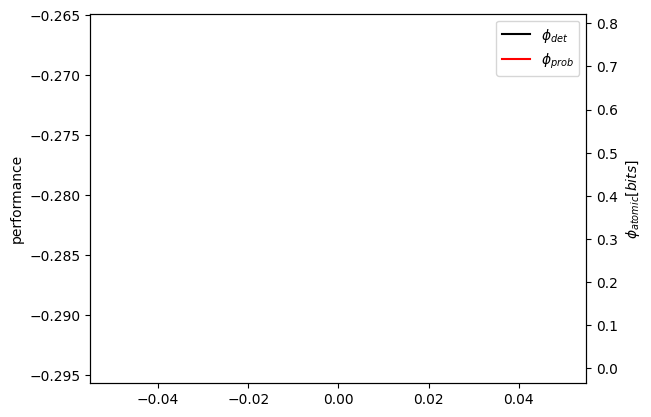

In [29]:
plot(W,label='performance')
ylabel('performance')
twinx()
plot(phi,'k',label=r"$\phi_{det}$")
plot(phiSamples,'r',label=r"$\phi_{prob}$")
ylabel(r"$\phi_{atomic} [bits]$")
legend()
savefig("phi.pdf")

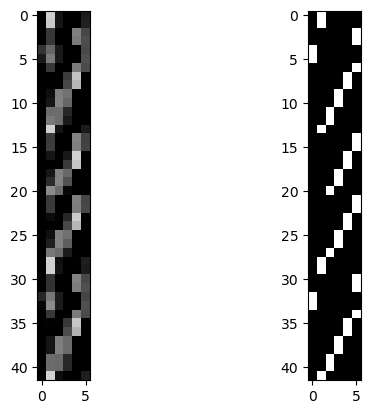

In [328]:
subplot(1,2,1)
imshow(numpy.roll(M,shift=-1,axis=0),vmin=0.0,vmax=1.0,cmap="gray")
subplot(1,2,2)
imshow(DaisyBellMatrix,cmap="gray")

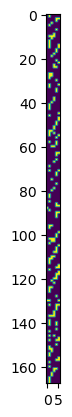

In [330]:
imshow(R)

([], [])

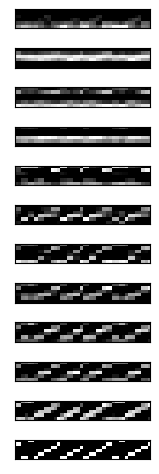

In [229]:
#figure(figsize=[3.25,1.25])
for o in range(10):
    subplot(12,1,o+1)
    imshow(Os[o].transpose(),cmap="gray",vmin=0.0)
    xticks([])
    yticks([])
tight_layout()
subplot(12,1,11)
imshow(Os[-1].transpose(),cmap="gray",vmin=0.0)
xticks([])
yticks([])
subplot(12,1,12)
imshow(DaisyBellMatrix.transpose(),cmap="gray",vmin=0.0)
xticks([])
yticks([])
#tight_layout()


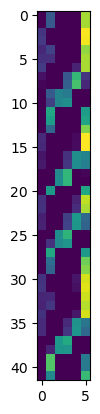

In [188]:
O=Os[10]
O=numpy.abs(O*(1.0*(O>=0.0)))
imshow((O.transpose()/O.sum(1)).transpose())

In [189]:
plot(target,answer,'.k')

In [111]:
O=output.detach().numpy()
O=(O*(1.0*(O>0.0)))
print(O)

[[[-0.          4.64955235 -0.         -0.         -0.
    4.71620655]]

 [[-0.          4.60671139 -0.         -0.         -0.
    4.75843668]]

 [[ 4.58779287 -0.         -0.         -0.         -0.
    4.8894496 ]]

 [[ 5.30454111 -0.         -0.         -0.          0.04894729
    4.70245886]]

 [[ 4.59989929 -0.         -0.         -0.         -0.
    5.08052826]]

 [[ 3.40157962 -0.         -0.         -0.         -0.
    4.92247868]]

 [[-0.         -0.         -0.          1.02906966  7.94073439
    3.10807848]]

 [[-0.         -0.         -0.          6.04761934  6.2900157
   -0.        ]]

 [[-0.         -0.         -0.          6.3077693   6.20473242
   -0.        ]]

 [[-0.         -0.          5.23940849  5.25566769 -0.
   -0.        ]]

 [[-0.         -0.          5.34251785  4.94773579 -0.
   -0.        ]]

 [[-0.          3.63474751  3.48890495 -0.         -0.
    2.52837467]]

 [[-0.          3.61038899  3.457757   -0.         -0.
    2.5791378 ]]

 [[-0.          5.66

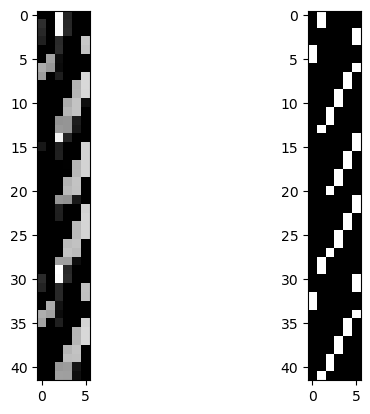

In [232]:
bptt=42
M=numpy.zeros((42,6))
for i in range(42):
    data,target=get_batch(DaisyBell,i)
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    model.eval()
    output = model(torch.tensor(data,dtype=torch.long),src_mask)
    M[i]=output.detach().numpy().reshape((bptt,6))[-1]
subplot(1,2,1)
imshow(numpy.roll(M,shift=1),vmin=0.0,cmap="gray")
subplot(1,2,2)
imshow(DaisyBellMatrix,vmin=0.0,cmap="gray")

In [233]:
M

array([[-3.61732411e+00,  5.37543535e+00,  7.99647093e-01,
        -2.42201257e+00, -8.99926841e-01,  9.74684298e-01],
       [-3.78051853e+00,  5.32374477e+00,  8.16112280e-01,
        -2.28453946e+00, -7.36243904e-01,  8.48447978e-01],
       [-3.91380095e+00,  5.28374434e+00,  8.59648168e-01,
        -2.14722848e+00, -6.14830852e-01,  6.94618106e-01],
       [-3.03551936e+00,  8.94988477e-01, -1.29198897e+00,
        -6.67495489e-01,  4.21270227e+00, -7.45388150e-01],
       [-2.95249295e+00,  9.30240929e-01, -1.27758861e+00,
        -7.68393099e-01,  4.14113235e+00, -6.91498518e-01],
       [ 3.48129845e+00,  3.01641703e-01, -1.89433849e+00,
        -2.26152992e+00, -2.58340120e+00,  3.63948107e+00],
       [ 3.24390864e+00,  2.34872222e-01, -1.99873602e+00,
        -2.03720498e+00, -2.14454913e+00,  3.32657552e+00],
       [-3.35277796e+00,  6.34858429e-01, -1.34238946e+00,
        -2.72466004e-01,  4.57711554e+00, -9.36182261e-01],
       [-4.18902445e+00, -1.67162395e+00, -6.627

In [25]:
targets

tensor([ 3849,    12,   300,  6302,  3989,  1930, 10559,   451,     4,     7,
            2,  1511, 10115,   942,  2439,   572,     1,    47,    30,  1990,
         3869,   315,    19,    29,   939,     2,    10,  2139,  4916, 16615,
          235,     3,    13,     7,    24,    17, 13737,    97,  7720,     4,
          881,    67,   807,  5402,     6,    38, 28188,    25,     2,    77,
            7,  2394,    17,   516,    14, 16403,  3714,  4618,    12,  1108,
            9,   196,  6041,   190,   218, 11776,    17,     1,  1200,     2,
            0,    10,   591,    40,  6004,     2,    50,     3,  3131,  3781,
        20000,    21,  6406,    14,     3,    10,     8,   114,    24,  2294,
         1684,  7156,  1681,   191,   928,  5879,    51,     9,  1147,     5])

In [1]:
bptt=5
data, targets = get_batch(train_data, 1)
print(data.shape,targets.shape)

NameError: name 'get_batch' is not defined

In [50]:
12%5

2

In [25]:
output

tensor([[[-1.5466, -0.8360, -0.6768, -0.5004, -0.4938,  3.2323]],

        [[-1.3803, -0.7228, -0.5060, -0.7009, -0.5490,  2.9875]],

        [[-1.4833, -0.8431, -0.5844, -0.6821, -0.2417,  2.9131]],

        [[-1.1066, -1.0999, -1.0482, -0.5969,  0.3707,  2.6071]],

        [[-1.4882, -1.4286, -1.0977, -0.2929,  0.5141,  2.9791]],

        [[-2.3027, -1.7583, -0.5509,  0.1020,  0.2049,  3.5118]],

        [[-2.4871, -1.5904, -0.1678, -0.0159, -0.1174,  3.5959]],

        [[-2.0026, -1.1550, -0.2251, -0.4764, -0.1607,  3.2757]],

        [[-2.6860, -1.3325, -0.5237,  0.0619,  0.1812,  3.1792]],

        [[-2.8779, -1.3933, -0.7564,  0.1797,  0.5048,  3.2523]],

        [[-3.0802, -1.3507, -0.0817, -0.0389,  0.0718,  3.6286]],

        [[-3.3767, -1.5165, -0.1724,  0.1201,  0.1192,  3.9511]],

        [[-3.2704, -0.9247,  0.0438, -0.2262, -0.0614,  3.9351]],

        [[-2.8094, -0.5650,  0.2289, -0.6448, -0.3370,  3.6598]],

        [[-2.4509, -0.7559, -0.2386, -0.6735, -0.1818,  3.6387

In [27]:
data

[[1],
 [1],
 [1],
 [5],
 [5],
 [0],
 [0],
 [5],
 [4],
 [4],
 [3],
 [3],
 [2],
 [2],
 [1],
 [5],
 [5],
 [4],
 [4],
 [3],
 [3],
 [2],
 [5],
 [5],
 [4],
 [4],
 [3],
 [3],
 [2],
 [1],
 [1],
 [5],
 [5],
 [0],
 [0],
 [5],
 [4],
 [4],
 [3],
 [3],
 [2],
 [2]]

In [29]:
src_mask.shape

torch.Size([42, 42])

In [32]:
O

array([0.        , 0.        , 0.05600245, 0.        , 0.20343632,
       3.209741  ], dtype=float32)